# RGBT Dataset `__getitem__` 디버깅 노트북

이 노트북은 LoadRGBTImagesAndLabels 클래스의 `__getitem__` 함수를 디버깅하기 위해 작성되었습니다.

**목표:**
1. 데이터 로드
2. 이미지와 라벨 시각화

In [1]:
import sys
from utils.dataloaders import LoadRGBTImagesAndLabels

In [2]:
import yaml

# hyperparameter 경로
with open('data/hyps/hyp.scratch-low.yaml', 'r') as f:
    hyp = yaml.safe_load(f)

# 데이터셋 인스턴스 생성
dataset = LoadRGBTImagesAndLabels(
    path='datasets/kaist-rgbt/train-all-04.txt',
    img_size=640,
    batch_size=1,
    augment=False,
    hyp=hyp,
    rect=False,
    cache_images=False,
    single_cls=False,
    stride=32,
    pad=0.0,
    image_weights=False,
    prefix='',
    rank=-1
)


Scanning datasets/kaist-rgbt/train-all-04.cache... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:00<?, ?it/s]


In [20]:
import random

# 데이터셋 길이
n = len(dataset)
start_idx = random.randint(0, n - 1)  # 랜덤 시작점

# 랜덤 시작점부터 한 바퀴 돌면서 라벨 있는 샘플 찾기
for offset in range(n):
    i = (start_idx + offset) % n
    imgs_i, labels_i, path_i, shapes_i, idx_i = dataset[i]
    if labels_i.shape[0] > 0:
        imgs, labels, path, shapes, idx = imgs_i, labels_i, path_i, shapes_i, idx_i
        print(f"✅ 선택된 인덱스: {i} (랜덤 시작점: {start_idx})")
        print(f"파일 경로: {path}")
        print(f"라벨 개수: {labels.shape[0]}")
        break
else:
    print("❌ 라벨이 존재하는 항목이 없습니다.")


✅ 선택된 인덱스: 3911 (랜덤 시작점: 3911)
파일 경로: datasets/kaist-rgbt/train/images/{}/set00_V008_I00163.jpg
라벨 개수: 2


lb: [          0           0     0.21016     0.46641    0.042188    0.095312]
lb: [          0           0     0.29219     0.47031    0.046875      0.0875]


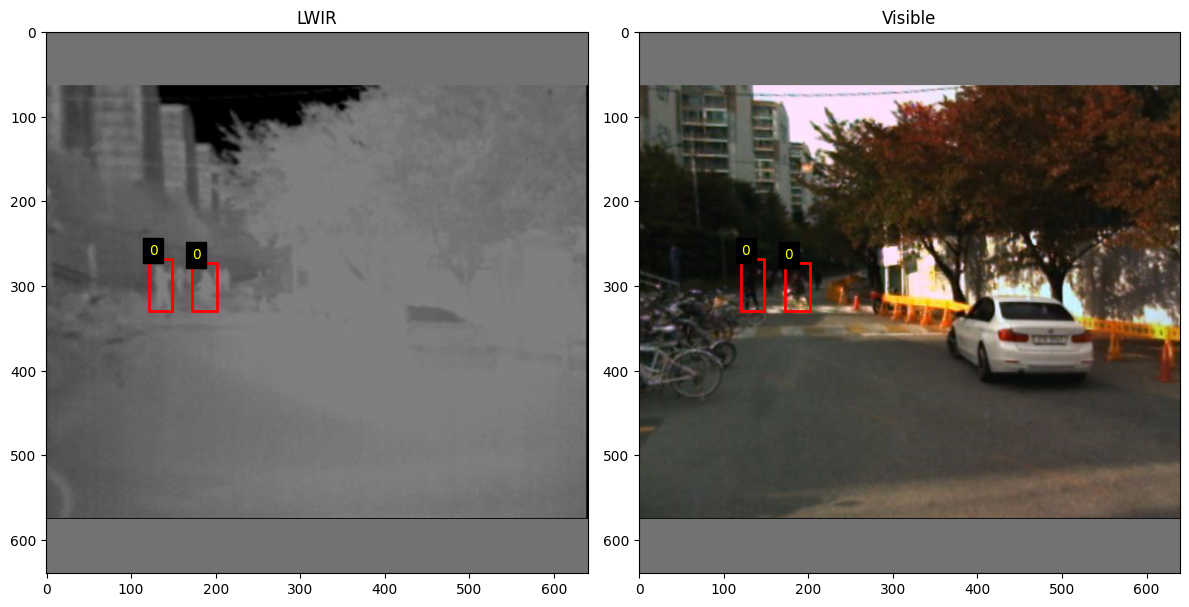

In [21]:
import matplotlib.pyplot as plt

# LWIR 및 VIS 텐서를 NumPy 배열로 변환 (CHW -> HWC)
lwir, vis = imgs
lwir_np = lwir.permute(1, 2, 0).numpy()
vis_np = vis.permute(1, 2, 0).numpy()
H, W = lwir_np.shape[:2]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(lwir_np)
axes[0].set_title('LWIR')
axes[1].imshow(vis_np)
axes[1].set_title('Visible')

# 라벨: [class, x_center, y_center, width, height]
for lb in labels.numpy():
    print("lb:", lb)
    _, cls, x, y, w, h = lb
    x1 = (x - w/2) * W
    y1 = (y - h/2) * H
    w_pixel = w * W
    h_pixel = h * H

    # Rectangle 박스
    rect0 = plt.Rectangle((x1, y1), w_pixel, h_pixel, edgecolor='r', fill=False, linewidth=2)
    rect1 = plt.Rectangle((x1, y1), w_pixel, h_pixel, edgecolor='r', fill=False, linewidth=2)
    axes[0].add_patch(rect0)
    axes[1].add_patch(rect1)

    # 클래스 텍스트 (왼쪽 위에 표시)
    axes[0].text(x1, y1 - 5, f'{int(cls)}', color='yellow', fontsize=10, backgroundcolor='black')
    axes[1].text(x1, y1 - 5, f'{int(cls)}', color='yellow', fontsize=10, backgroundcolor='black')

plt.tight_layout()
plt.show()
